# RDKit Heatmaps
This module allows to draw heatmaps to molecular depictions, analogous to the function `rdkit.Chem.Draw.rdMolDraw2D.ContourAndDrawGaussians`.  
Contrasting the original implementation, this module offers 2-dimensional Gauss-functions, allowing to stretch the distribution. These 'stretched' distributions are used to highlight bonds. Additionally here the range of depicted values can be set manually for a consistent visualization over differing drawings. Contourlines are not supported, yet.
## Disclaimer
This package is still under development. Usage at own risk.

## Installation in Conda
If not already installed, install **pip** and **git**:  
```
conda install git
conda install pip
```
Then install via pip:
```
pip install git+git://github.com/c-feldmann/rdkit_heatmaps
```

## Quickstart
### Mapping values to a molecule
Loading required packages.

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw

In [2]:
%load_ext autoreload
%autoreload 2

Loading packages required for this example:

In [3]:
import numpy as np

Loading functions of this package.

In [4]:
from rdkit_heatmaps import mapvalues2mol
from rdkit_heatmaps.utils import transform2png

Definition and preparation of an exemplary compound.

In [5]:
test_mol = Chem.MolFromSmiles("c1ccccc1-C-c2ccccc2")
test_mol = Draw.PrepareMolForDrawing(test_mol)

Sampling values as exemplary weights for atoms and bonds:

In [6]:
random_generator = np.random.default_rng(12345)
atom_weights = random_generator.normal(loc=0.25, scale=0.25, size=len(test_mol.GetAtoms()))
bond_weights = random_generator.normal(loc=-0.25, scale=0.25, size=len(test_mol.GetBonds()))

Mapping obtained values to the molecule.

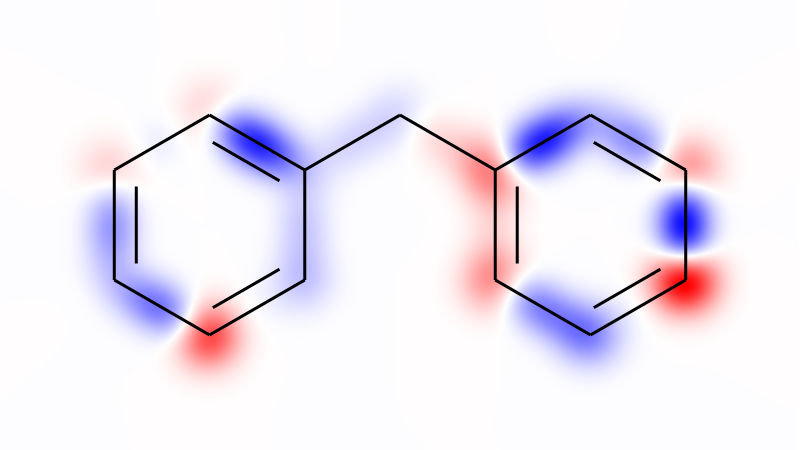

In [7]:
canvas = mapvalues2mol(test_mol, atom_weights, bond_weights)
img = transform2png(canvas.GetDrawingText())
img

## Options
### Width and length of depicted Gauss-functions
The width and length of depicted Functions can be varied using the parameters `atom_width`, `bond_length`, and `bond_width`.

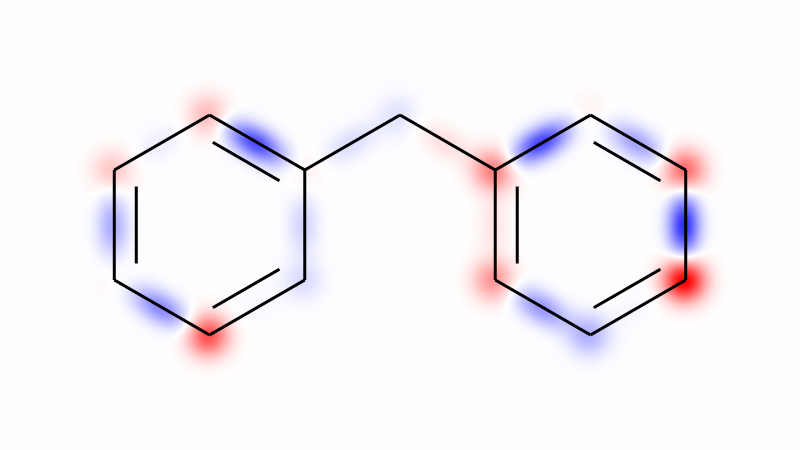

In [8]:
canvas = mapvalues2mol(test_mol, atom_weights, bond_weights, atom_width=0.2, bond_length=0.3, bond_width=0.15)
img = transform2png(canvas.GetDrawingText())
img

### Specifying colormap
The parameter `color` accepts string representations of matplotlib colors and `Colormap`-objects of matplotlib.

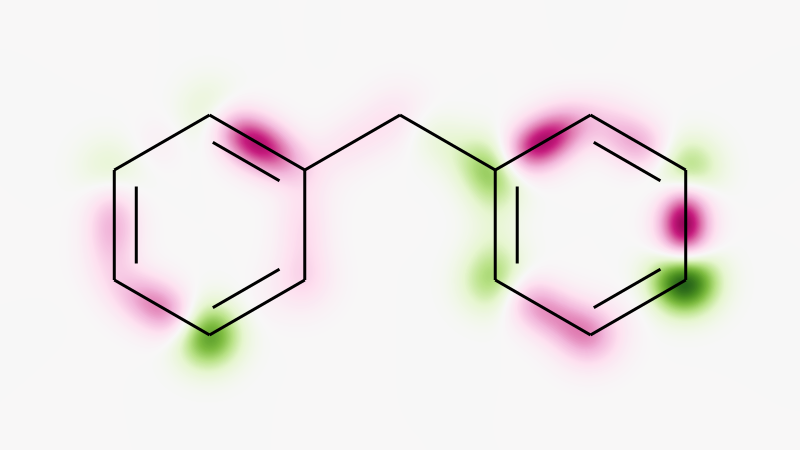

In [9]:
canvas = mapvalues2mol(test_mol, atom_weights, bond_weights, color="PiYG")
img = transform2png(canvas.GetDrawingText())
img

### Specifying boundaries of depicted values

In [10]:
from rdkit_heatmaps import get_depiction_limits

In [11]:
min_value, max_value = get_depiction_limits(test_mol, atom_weights, bond_weights)
print("Values range from {:0.2f} to {:0.2f}".format(min_value, max_value))

Values range from -0.60 to 0.64


In [12]:
artificial_limit = [-2, 2]

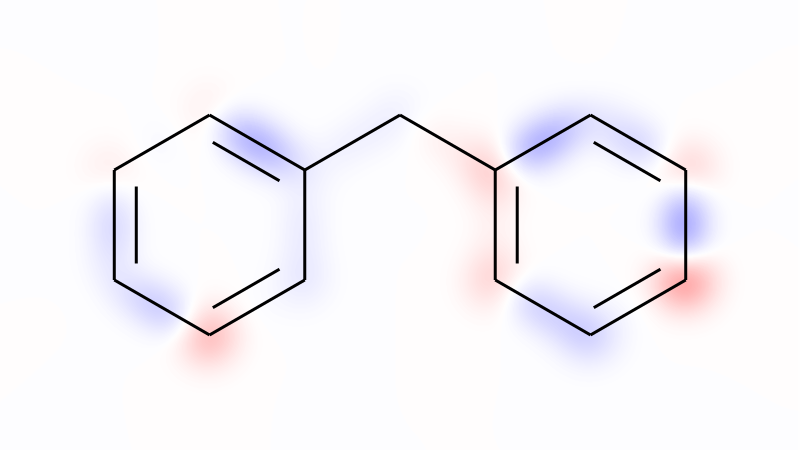

In [13]:
canvas = mapvalues2mol(test_mol, atom_weights, bond_weights, value_lims=artificial_limit)
img = transform2png(canvas.GetDrawingText())
img

### Miscellaneous options
* `canvas` (`rdMolDraw2D.MolDraw2D`): Rdkit Canvas to draw on. If none is given, a new one is created 
* `grid_resolution` (`[int, int]`): number of drawn pixels (x and y axis)
* `padding` (`[float, float]`): increase of height and width of heatmap relative to space of drawn molecule (usually increased by 100%)

## Function
### Step 0: Loading functions

In [14]:
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit_heatmaps import utils
from rdkit_heatmaps.heatmaps import ValueGrid
from rdkit_heatmaps.heatmaps import color_canvas
from rdkit_heatmaps.functions import GaussFunction2D

### Step 1: Creating a RDKit Canvas

In [15]:
canvas = rdMolDraw2D.MolDraw2DCairo(800, 450)
draw_opt = canvas.drawOptions()
draw_opt.padding = 0.2
draw_opt.bondLineWidth = 3
canvas.SetDrawOptions(draw_opt)

# Drawing the molecule and erasing it to initialize the grid-coordinates
canvas.DrawMolecule(test_mol)
canvas.ClearDrawing()

### Step 2: Setting up the Grid

In [16]:
grid_resolution = [canvas.Width(), canvas.Height()]
grid_padding = padding = [draw_opt.padding * 2, draw_opt.padding * 2]

Getting the size of the molecule

In [17]:
xl, yl = utils.get_mol_lims(test_mol)
xl, yl = list(xl), list(yl) # Transformation from tuple to list

Estimating Canvas size it molecular coordinates (would be nice if this was directly accessible)

In [18]:
# Canvas-size without padding
mol_height = yl[1] - yl[0]
mol_width = xl[1] - xl[0]

height_to_width_ratio_mol = mol_height / mol_width
height_to_width_ratio_canvas = canvas.Height() / canvas.Width()

if height_to_width_ratio_mol < height_to_width_ratio_canvas:
    mol_height_new = canvas.Height() / canvas.Width() * mol_width
    yl[0] -= (mol_height_new - mol_height) / 2
    yl[1] += (mol_height_new - mol_height) / 2
else:
    mol_width_new = canvas.Width() / canvas.Height() * mol_height
    xl[0] -= (mol_width_new - mol_width) / 2
    xl[1] += (mol_width_new - mol_width) / 2

# Canvas-size with padding
xl = utils.pad(xl, grid_padding[0])  # Increasing size of x-axis
yl = utils.pad(yl, grid_padding[1])  # Increasing size of y-axis

Setting out the Grid which holds the values

In [19]:
value_grid = ValueGrid(xl, yl, grid_resolution[0], grid_resolution[1])

### Step 3: Adding Atom- and Bond-Functions to Value Grid

In [20]:
conf = test_mol.GetConformer(0)
atom_width = 0.3
bond_width = 0.25
bond_length = 0.5

In [21]:
for i, _ in enumerate(test_mol.GetAtoms()):
    if atom_weights[i] == 0:
        continue
    pos = conf.GetAtomPosition(i)
    coords = pos.x, pos.y
    f = GaussFunction2D(center=coords, std1=atom_width, std2=atom_width, scale=atom_weights[i], rotation=0)
    value_grid.add_function(f)

# Adding Gauss-functions centered at bonds (position between the two bonded-atoms)
for i, b in enumerate(test_mol.GetBonds()):  # type: Chem.Bond
    if bond_weights[i] == 0:
        continue
    a1 = b.GetBeginAtom().GetIdx()
    a1_pos = conf.GetAtomPosition(a1)
    a1_coords = np.array([a1_pos.x, a1_pos.y])

    a2 = b.GetEndAtom().GetIdx()
    a2_pos = conf.GetAtomPosition(a2)
    a2_coords = np.array([a2_pos.x, a2_pos.y])

    diff = a2_coords - a1_coords
    angle = np.arctan2(diff[0], diff[1])

    bond_center = (a1_coords + a2_coords) / 2

    f = GaussFunction2D(center=bond_center, std1=bond_width, std2=bond_length, scale=bond_weights[i],
                        rotation=angle)
    value_grid.add_function(f)

### Step 4: Evaluating the function for each grid point and transforming it to color-value

In [22]:
value_grid.evaluate()
abs_max = np.abs(value_grid.values).max()
color_grid = value_grid.map2color("bwr", v_lim=[-abs_max, abs_max])

### Step 5: Drawing the heatmap to the canvas
Each pixel is drawn to the canvas as Rectangle (`rdkit.Draw.MolDraw2D.DrawRect`).

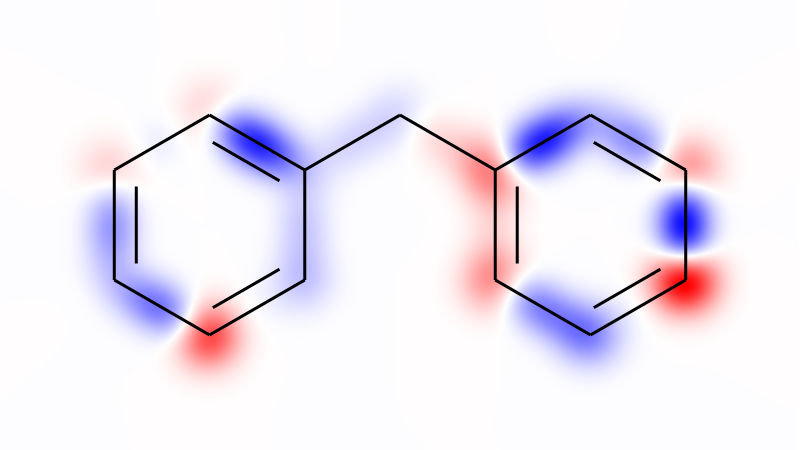

In [23]:
# Adding the Colormap to the canvas
color_canvas(canvas, color_grid)
# Adding the molecule to the canvas
canvas.DrawMolecule(test_mol)
img = transform2png(canvas.GetDrawingText())
img

## Other features of this package
### Drawing Images
Using the grid-parameter from prior section to set up a `ColorGrid` and an image to set the colors.

In [24]:
from rdkit_heatmaps import heatmaps
from PIL import Image

In [25]:
image = np.array(Image.open('pictures/039.jpg'))
image = image / 255
image = np.flip(image, axis=0)
ones = np.ones([*image.shape[:2], 1])
image = np.append(image, ones, axis=2)
image = np.swapaxes(image,1,0)
c_grid = heatmaps.ColorGrid(xl, yl, image.shape[0], image.shape[1])
c_grid.color_grid = image

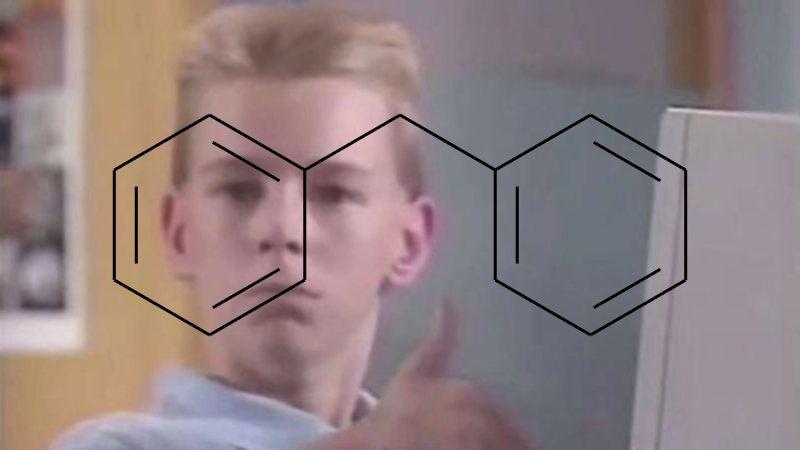

In [26]:
d = rdMolDraw2D.MolDraw2DCairo(800, 450)
do = d.drawOptions()
do.padding = 0.2
do.bondLineWidth = 3
d.SetDrawOptions(do)
d.DrawMolecule(test_mol)
heatmaps.color_canvas(d, c_grid)
d.DrawMolecule(test_mol)
transform2png(d.GetDrawingText())

### Mapping custom functions

In [27]:
from rdkit.Chem import AllChem
from rdkit.Chem.Draw.rdMolDraw2D import MolDraw2DCairo
from rdkit.Chem.Draw.rdMolDraw2D import MolDraw2DSVG
from rdkit.Chem.Draw.rdMolDraw2D import MolDrawOptions
from rdkit.Geometry.rdGeometry import Point2D
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.display import SVG
from rdkit_heatmaps import heatmaps
from rdkit_heatmaps.utils import get_mol_lims
from rdkit_heatmaps.utils import pad
from rdkit_heatmaps.functions import GaussFunction2D

## Other things

#### Using your own colormap

In [28]:
from matplotlib.colors import ListedColormap

# Definition of color
yellow = np.array([1, 1, 0, 1])
white  = np.array([1, 1, 1, 1])
purple = np.array([1, 0, 1, 1])

# Creating linear gradient for color mixing
linspace = np.linspace(0, 1, int(128))
linspace4d = np.vstack([linspace]*4).T

# interpolating values for 0 to 0.5 by mixing purple and white
zero_to_half = linspace4d * white + (1-linspace4d) * purple
# interpolating values for 0.5 to 1 by mixing white and yellow
half_to_one = yellow * linspace4d + white * (1-linspace4d)

# Creating new colormap from 
newcmp = ListedColormap(np.vstack([zero_to_half,half_to_one]))

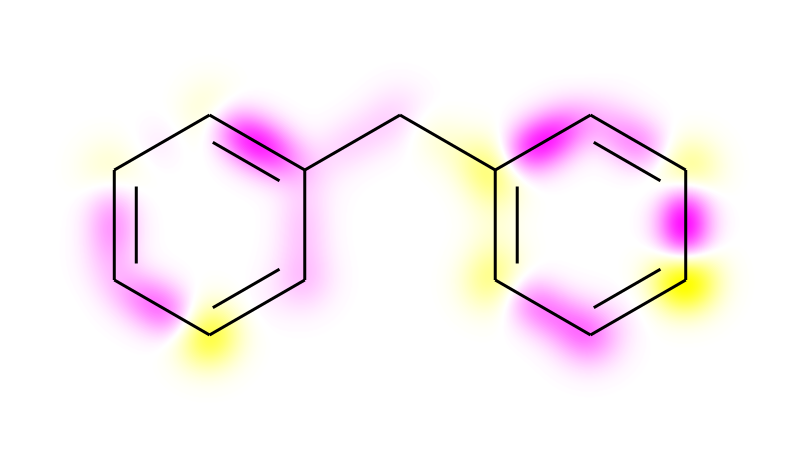

In [29]:
canvas = mapvalues2mol(test_mol, atom_weights, bond_weights, color=newcmp)
img = transform2png(canvas.GetDrawingText())
img

### Rotating the molecule

In [30]:
AllChem.Compute2DCoords(test_mol)
angle = -np.pi *0.5
r_mat = np.array([[np.cos(angle), -np.sin(angle), 0, 0],
                  [np.sin(angle), np.cos(angle), 0, 0],
                  [0, 0 ,1 , 0],
                  [0, 0 ,0 , 1]])
AllChem.TransformMol(test_mol, r_mat)

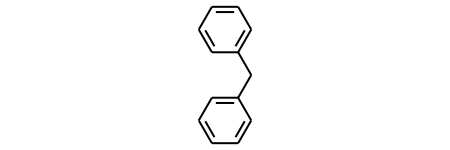

In [31]:
test_mol